<a href="https://colab.research.google.com/github/monta0315/DGM-and-VR/blob/main/DGM/DGM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#サマースクール生成モデルコース　第二回

In [9]:
%matplotlib inline

import PIL
PIL.PILLOW_VERSION = PIL.__version__

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional  as F
from torchvision import datasets,transforms,models

import matplotlib.pyplot as plt

rng = np.random.RandomState(1234)
random_state = 42

1. Variational auto-encoder (VAE)の実装
  - 1.1. MNISTデータセットの読み込み
  - 1.2. VAEの実装
  - 1.3. 学習
2. 再構成画像の可視化
  - 2.1. Original image
  - 2.2. Reconstruction image
3. 潜在変数からランダムサンプリング
4. 潜在空間の多様体の可視化

In [2]:
x = torch.randn(4,4,4)
print(x.size())

y = x.view(-1)
print(y.size())

torch.Size([4, 4, 4])
torch.Size([64])


In [3]:
#mnistデータセットの読み込み
#x.view(-1)では入力画像の一次元化をしている

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Lambda(lambda x: x.view(-1))
])
batch_size = 100
device='cuda'
n_epochs = 20

dataloader_train = torch.utils.data.DataLoader(
    datasets.MNIST('./data/MNIST',train=True,download=True,transform=transform),
    batch_size = batch_size,
    shuffle = False,
)

dataloader_valid = torch.utils.data.DataLoader(
    datasets.MNIST('./data/MNIST',train=False,download=True,transform=transform),
    batch_size=batch_size,
    shuffle= False,
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


#VAEの実装

VAEのエンコーダとデコーダは、それぞれ次のように表されます。
- エンコーダ（ガウス分布）：$q_{\phi}({\bf z}|{\bf x}) = {\mathcal N}({\bf z}; \mu,\sigma^2{\bf I})$, ただし$\mu=g^{\mu}_{\phi}({\bf x}), \sigma=g^{\sigma}_{\phi}({\bf x})$.
- デコーダ（ベルヌーイ分布）：$p_{\theta}({\bf x}|{\bf z}) = Ber({\bf x}; \lambda)$, ただし$\lambda=f_{\theta}({\bf z})$.


また、VAEの下界（目的関数）は次のとおりです。

${\mathcal L}({\bf x};{\bf \theta},{\bf \phi}) = E_{q_{\phi}({\bf z}|{\bf x})}[\log p_\theta({\bf x}|{\bf z})] -D_{KL}[q_{\phi}({\bf z}|{\bf x})||p_{\theta}({\bf z})]$

第1項が（負の）再構成誤差、第2項が正則化項に対応しています。

- 第1項は、次のように計算できます。

  $E_{q_{\phi}({\bf z}|{\bf x})}[\log p_\theta({\bf x}|{\bf z})]=\frac{1}{L}\sum_{l=1}^L\log p_\theta({\bf x}|{\bf z}^{(l)})$,  ただし$ {\bf z}^{(l)} = \mu + \sigma \odot \epsilon^{(l)}, \epsilon^{(l)}\sim N(0,{\bf I})$.

  なおデコーダはベルヌーイ分布なので、右辺は次のように計算できます。
  
  $\frac{1}{L}\sum_{l=1}^L\log p_\theta({\bf x}|{\bf z}^{(l)})=\frac{1}{L}\sum_{l=1}^L \sum_{i=1}^D x_i \log \lambda^{(l)}_i + (1-x_i)\log (1-\lambda^{(l)}_i)$,  ただし$\lambda^{(l)}=f_{\theta}({\bf z}^{(l)})$.  
  （実装内の`reconstruction`に対応、簡単のため今回の演習では$L=1$を採用）


- また第2項については、次のように解析的に計算できます（ただし、$p_{\theta}({\bf z})={\cal N}(0,{\bf I})$とする）。
  $D_{KL}[q_{\phi}({\bf z}|{\bf x})||p_{\theta}({\bf z})] = -\frac{1}{2}\sum_{j=1}^J(1+\log((\sigma_j)^2)-(\mu_j)^2-(\sigma_j)^2)$  
  （実装内の`KL`に対応）

In [14]:
#torch.log(0)によるNaNを防ぐ
#torch.clampで最小値の値を制限することで小さすぎてNaN値になることを防いでいる？
def torch_log(x):
    return torch.log(torch.clamp(x,min=1e-10))

class VAE(nn.Module):
    def __init__(self,z_dim):
        super(VAE,self).__init__()
        #Encoder,xを入力にガウス分布のパラメータmu,sigmaを出力
        self.dense_enc1 = nn.Linear(28*28,200)
        self.dense_enc2 = nn.Linear(200,200)
        self.dense_encmean = nn.Linear(200,z_dim)
        self.dense_encvar = nn.Linear(200,z_dim)
        #Decoder,zを入力にベルヌーイ分布のパラメータlambdaを出力
        self.dense_dec1 = nn.Linear(z_dim,200)
        self.dense_dec2 = nn.Linear(200,200)
        self.dense_dec3 = nn.Linear(200,28*28)

        #エンコーダのencmean,encvarはガウス分布のパラメータに必要な平均と分散を出力するように二つの層を追加している？？
    
    def _encoder(self,x):
        x = F.relu(self.dense_enc1(x))
        x = F.relu(self.dense_enc2(x))
        mean = self.dense_encmean(x)

        #マイナスの値を取らないように
        #なんでstdって名前？
        #softplus(今回はβを指定していないから)はlog(1+exp(x))の出力値
        std = F.softplus(self.dense_encvar(x))
        return mean,std

    def _sample_z(self,mean,std):
        #再パラメータ化トリック
        #φの勾配が推論分布に伝わらなくなる現象を解決するために、、、 z = μ + σ*ε
        epsilon = torch.randn(mean.shape).to(device)
        return mean + std*epsilon

    def _decoder(self,z):
        x = F.relu(self.dense_dec1(z))
        x = F.relu(self.dense_dec2(x))
        #出力値が0~1の間になるようにするため
        x  = torch.sigmoid(self.dense_dec3(x))
        return x

    def forward(self, x):
        mean, std = self._encoder(x)
        z = self._sample_z(mean, std)
        x = self._decoder(z)
        return x, z

    def loss(self,x):
        mean ,std = self._encoder(x)
        #KL lossの計算
        KL = -0.5 * torch.mean(torch.sum(1 + torch_log(std**2) - mean**2 - std**2, dim=1))
        z = self._sample_z(mean,std)
        y = self._decoder(z)

        #reconstruction lossの計算（再構成誤差）
        reconstruction = torch.mean(torch.sum(x * torch_log(y) + (1 - x) * torch_log(1 - y), dim=1))

        return KL,-reconstruction

In [15]:
#学習
z_dim = 10
model = VAE(z_dim).to(device)
optimizer = optim.Adam(model.parameters(),lr=0.001)

for epoch in range(n_epochs):
    losses = []
    KL_losses = []
    reconstruction_losses = []
    model.train()
    for x,_ in dataloader_train:
        x = x.to(device)
        #zero_gradを使用している理由＝＞Pytorchではデフォルトで逆伝搬で勾配を計算する際に以前に計算した勾配がある場合はそれを加算するようになっている、
        #しかし、前回の勾配の結果を足したくない場合はbackward()を呼び出す前にzero_grad()を行う必要がある
        model.zero_grad()

        KL_loss,reconstruction_loss = model.loss(x) #lossの各項の計算

        #エビデンス下界の最大化=>マイナスをかけた値を最小化するようにパラメータを更新
        loss = KL_loss + reconstruction_loss #和をとってlossとする

        loss.backward()
        optimizer.step()

        losses.append(loss.cpu().detach().numpy())
        KL_losses.append(KL_loss.cpu().detach().numpy())
        reconstruction_losses.append(reconstruction_loss.cpu().detach().numpy())
    
    losses_val = []
    model.eval()

    for x,t in dataloader_valid:
        x = x.to(device)
        KL_loss, reconstruction_loss = model.loss(x)

        loss = KL_loss + reconstruction_loss

        losses_val.append(loss.cpu().detach().numpy())

    print('EPOCH:%d, Train Lower Bound:%lf, (%lf, %lf), Valid Lower Bound:%lf' %
          (epoch+1, np.average(losses), np.average(KL_losses), np.average(reconstruction_losses), np.average(losses_val)))


EPOCH:1, Train Lower Bound:189.022461, (5.656094, 183.366364), Valid Lower Bound:154.002136
EPOCH:2, Train Lower Bound:139.932785, (11.951403, 127.981377), Valid Lower Bound:130.264404
EPOCH:3, Train Lower Bound:125.735184, (14.077379, 111.657814), Valid Lower Bound:124.017410
EPOCH:4, Train Lower Bound:120.656105, (14.661531, 105.994568), Valid Lower Bound:119.083328
EPOCH:5, Train Lower Bound:117.617760, (15.030320, 102.587433), Valid Lower Bound:117.525299
EPOCH:6, Train Lower Bound:115.695160, (15.307707, 100.387451), Valid Lower Bound:117.121887
EPOCH:7, Train Lower Bound:113.732498, (15.859147, 97.873360), Valid Lower Bound:113.440567
EPOCH:8, Train Lower Bound:112.036278, (16.298059, 95.738213), Valid Lower Bound:112.343231
EPOCH:9, Train Lower Bound:110.927238, (16.511858, 94.415375), Valid Lower Bound:111.177452
EPOCH:10, Train Lower Bound:109.974632, (16.645046, 93.329582), Valid Lower Bound:109.586937
EPOCH:11, Train Lower Bound:109.268127, (16.756268, 92.511848), Valid Lowe

#再構成画像の可視化

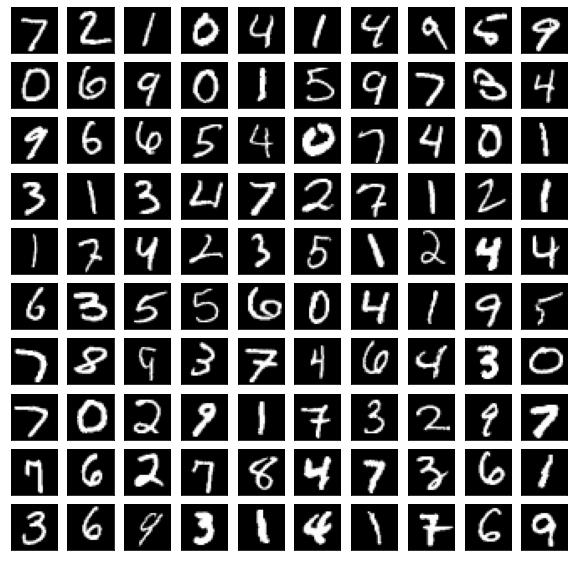

In [16]:
#original image
valid_dataset = datasets.MNIST('./data/MNIST', train=False, download=True, transform=transform)
fig = plt.figure(figsize=(10, 10))
model.eval()
for i in range(100):
    x, t = valid_dataset[i]
    im = x.view(-1, 28, 28).permute(1, 2, 0).squeeze().numpy()
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

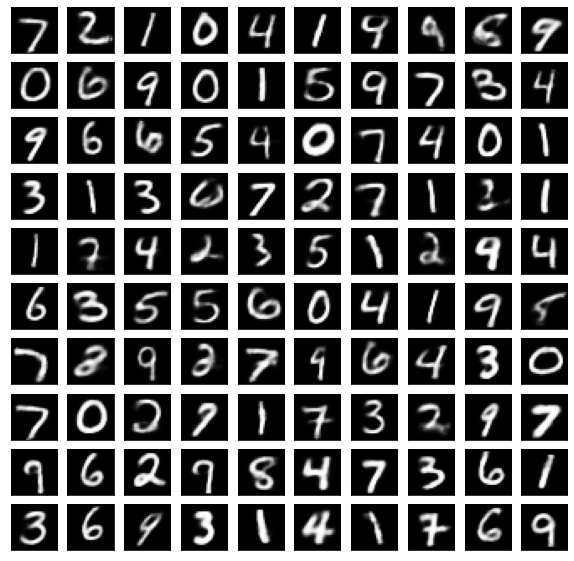

In [17]:
valid_dataset = datasets.MNIST('./data/MNIST', train=False, download=True, transform=transform)
fig = plt.figure(figsize=(10, 10))
model.eval()
for i in range(100):
    x, t = valid_dataset[i]
    x = x.to(device)
    x = x.unsqueeze(0)
    y, z = model(x)
    im = y.view(-1, 28, 28).permute(1, 2, 0).cpu().squeeze().detach().numpy()
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

#潜在変数からのランダムなサンプリング

tensor([[-0.5028, -0.7860, -0.4372, -0.7476,  1.3945, -2.2700,  0.6543, -0.2767,
          0.0771,  1.5586]], device='cuda:0')
tensor([[ 1.2004,  0.3272, -0.7152,  0.3342,  0.6924, -0.2813, -0.2413, -0.7423,
         -0.5373, -0.2964]], device='cuda:0')
tensor([[-1.2152, -0.7561, -0.0234, -1.0933,  0.2257,  0.4386, -0.7708,  2.9265,
          0.6873,  0.5854]], device='cuda:0')
tensor([[ 0.3638,  0.9719, -0.1274, -0.3783, -0.2013, -0.0382,  1.5877,  1.0171,
         -0.4630, -0.4800]], device='cuda:0')
tensor([[ 1.0280, -0.4878, -0.0696,  0.9281, -1.6667, -1.4139, -0.8125,  0.6352,
         -0.3218, -0.0161]], device='cuda:0')
tensor([[ 1.5975, -0.3385,  0.6378, -0.9297, -0.3002,  0.2861, -2.4444,  1.9635,
          1.0670,  0.8598]], device='cuda:0')
tensor([[ 0.0539,  0.1287, -0.3849,  0.4611, -1.7159, -0.6257, -0.1204, -2.0425,
         -1.5262, -1.4565]], device='cuda:0')
tensor([[ 0.5233, -0.7007,  0.6839, -0.3240, -1.1889, -1.3825,  1.0329,  0.1556,
         -0.2657,  1.6307]], d

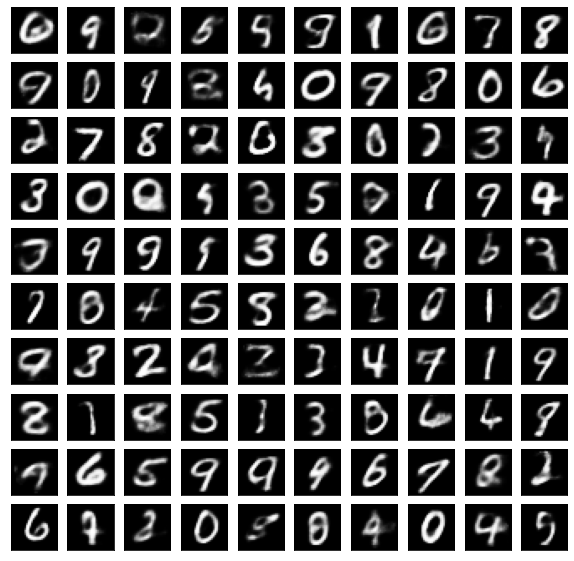

In [19]:
fig = plt.figure(figsize=(10,10))
model.eval()
for i in range(100):
    z = torch.randn([1,z_dim]).to(device)
    print(z)
    y = model._decoder(z)
    im = y.view(-1, 28, 28).permute(1, 2, 0).cpu().squeeze().detach().numpy()
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')


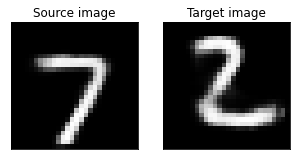

In [20]:
valid_dataset = datasets.MNIST('./data/MNIST', train=False, download=True, transform=transform)
fig = plt.figure(figsize=(5, 5))
model.eval()

x0, t = valid_dataset[0]
x0 = x0.to(device)
x0 = x0.unsqueeze(0)
y0, z0 = model(x0)
im = y0.view(-1, 28, 28).permute(1, 2, 0).cpu().squeeze().detach().numpy()
ax0 = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax0.set_title('Source image')
ax0.imshow(im, 'gray')

x1, t = valid_dataset[1]
x1 = x1.to(device)
x1 = x1.unsqueeze(0)
y1, z1 = model(x1)
im = y1.view(-1, 28, 28).permute(1, 2, 0).cpu().squeeze().detach().numpy()
ax1 = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax1.set_title('Target image')
ax1.imshow(im, 'gray')

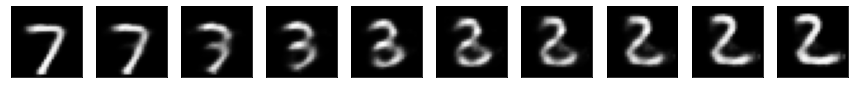

In [21]:
fig = plt.figure(figsize=(15, 15))
z_linear = torch.cat([z1 * (i * 0.1) + z0 * ((9 - i) * 0.1) for i in range(10)])
z_linear = z_linear.view((10, -1))
y2 = model._decoder(z_linear).view(-1, 28, 28)
for i, im in enumerate(y2.cpu().detach().numpy()):
    ax = fig.add_subplot(1, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

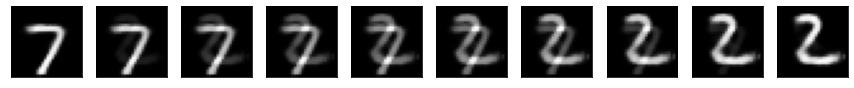

In [22]:
# 画像空間上でのデータ間の遷移
fig = plt.figure(figsize=(15, 15))
for i in range(10):
    ax = fig.add_subplot(1, 10, i+1, xticks=[], yticks=[])
    im = (y2[0] * (9 - i) + y2[-1] * i) / len(y2)
    ax.imshow(im.cpu().detach().numpy(), 'gray')